# Binary Regression Optimal Design for Different Link Functions

## Import packages

In [2]:
import pyswarms as ps
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

## Some API functions

In [3]:
def logit(x, alpha, beta):
    eta = alpha + beta * x 
    return np.exp(eta) / (1 + np.exp(eta)) **2
def probit(x, alpha, beta):
    eta = alpha + beta * x 
    Phi = stats.norm.cdf(eta)
    return np.exp(-eta**2) / (2*np.pi*Phi*(1-Phi))
def cox(x, alpha, beta):
    eta = alpha + beta * x 
    return (np.exp(2*eta-np.exp(eta))) / (1-np.exp(-np.exp(eta)))
def laplace(x, alpha, beta):
    eta = alpha + beta * x 
    return np.exp(-2*np.abs(eta) - np.log(stats.laplace.cdf(eta)) -np.log( stats.laplace.cdf(-eta)))
def student(x, alpha, beta):
    eta = alpha + beta * x 
    return stats.t.pdf(eta, 2) ** 2 / (stats.t.cdf(eta, 2) * stats.t.pdf(-eta, 2))

def info(x, alpha, beta, link="logit"):
    hi = np.zeros((2, 2))
    if link == "logit":
        weight = logit(x, alpha, beta)
    elif link == "probit":
        weight = probit(x, alpha, beta)
    elif link == "cox":
        weight = cox(x, alpha, beta)
    elif link == "laplace":
        weight = laplace(x, alpha, beta)
    elif link == "t":
        weight = student(x, alpha, beta)
    else:
        print("Please write your own code for your own link function!")
        return 
        
    hi[0, 0] = np.sum(weight)
    hi[0, 1] = hi[1, 0] = np.sum(weight*x)
    hi[1, 1] = np.sum(weight * (x ** 2))
    return hi

def D_optim(b, **kwargs):
    """D-optim design

    Parameters
    ----------
    b : numpy.ndarray
        sets of inputs shape :code:'(n_particles, dimensions)'
        usually for a simple logistic model, dimension is 8.

    Returns
    ----------
    numpy.ndarray
        computed cost of size :code:'(n_particles, )'
    """
    alpha, beta, link = kwargs.values()

    n, d = b.shape
    loss = np.zeros(n)
    
    for i in range(n):
        m = np.zeros((2, 2))
        x = b[i, :(d//2)]
        #x[1] = -x[0]
        p = b[i, (d//2):]
        #p[-1] = 1 - np.sum(p) + p[-1]
        p = p / np.sum(p)
        
        for j in range((d//2)):
            #print(info(x[j], alpha, beta))
            m += p[j] * info(x[j], alpha, beta, link) #p[j] * (ca.dot(ca.T))#
            
        #m = np.linalg.inv(m)
        
        loss[i] = np.linalg.det(m)
        if p[-1] < 0:
            loss[i] -= 1e200
        
    return -loss

def sensitivity(x, design, alpha, beta, link="logit"):
    """
    This function calculates the sensitivity function of a design.
    """
    n = x.shape[0]
    d = len(design)
    design_point = design[:(d//2)]
    p = design[(d//2):]
    M = np.zeros((2, 2))
    for j in range((d//2)):
        M += p[j] * info(design_point[j], alpha, beta, link)
    inv_M = np.linalg.inv(M)        
    output = np.zeros(n)

    for i in range(n):  
        if link == "logit":
            ca = logit(x[i, 1], alpha, beta)
        elif link == "probit":
            ca = probit(x[i, 1], alpha, beta)
        elif link == "cox":
            ca = cox(x[i, 1], alpha, beta)
        elif link == "laplace":
            ca = laplace(x[i, 1], alpha, beta)
        elif link == "t":
            ca = student(x, alpha, beta)
        output[i] = (ca * x[i, :]).dot(inv_M).dot(x[i, :]) - 2
    return output

## Run PSO!

In [4]:
n = 50 # number of particles
d = 6 # dimension of the problem
b = np.random.random((n, d))
link_type = "probit"
a = 0
b = 1
bounds = [tuple(np.concatenate([[-10.] * (d//2), [0]* (d//2)])),
          tuple(np.concatenate([[10] * (d//2), [1]* (d//2)]))]

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=d, options=options, bounds=bounds)
best_cost, best_pos = optimizer.optimize(D_optim, iters=600, alpha=a, beta=b, link=link_type)
best_pos[(d // 2):] = best_pos[(d // 2):] / np.sum(best_pos[(d // 2):])

2022-05-18 03:23:09,847 - pyswarms.single.global_best - INFO - Optimize for 600 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/600<ipython-input-3-58eeef1e2507>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-eta**2) / (2*np.pi*Phi*(1-Phi))
/Users/elviscui/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
pyswarms.single.global_best: 100%|██████████|600/600, best_cost=-.199
2022-05-18 03:23:18,282 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.19868373110621543, best pos: [-1.13810128 -1.13800334  1.13810802  0.57616512  0.05392177  0.63008668]


In [5]:
print("Design points:")
print(np.round(best_pos[:(d//2)], 5))
print("Design weights:")
print(np.round(best_pos[(d//2):], 5))

b * best_pos[:(d//2)] + a

Design points:
[-1.1381  -1.138    1.13811]
Design weights:
[0.45721 0.04279 0.5    ]


array([-1.13810128, -1.13800334,  1.13810802])

Text(0.5, 1.0, 'probit: a=0 b=1')

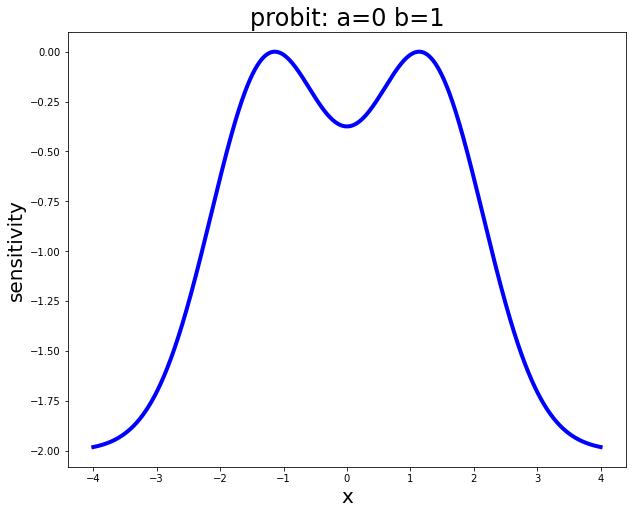

In [6]:
num = 1000
low = -4; upp = 4
x = np.stack((np.ones((num, )), np.linspace(low, upp, num))).T

biao = sensitivity(x, best_pos, a, b, link_type)

plt.figure(figsize=(10, 8))
plt.plot(np.linspace(low, upp, num), biao, c="blue", linewidth=4)
plt.xlabel("x", fontsize=20)
plt.ylabel("sensitivity", fontsize=20)
plt.title(link_type+": a="+str(a)+" b="+str(b), fontsize=24)